# Exploratory Data Analysis
We'll start by importing packages, reading the data into a dataframe, and checking the datatypes and for nulls. Convenience functions have been written separately so as not to clog up the notebook unnecessarily; see `utils.py` for details.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils

In [2]:
raw = pd.read_csv('data/raw.csv')
raw.head()

,Location,Date,Time,Latitude,Longitude,Altitude,YRMODAHRMI,Month,Hour,Season,Humidity,AmbientTemp,PolyPwr,Wind.Speed,Visibility,Pressure,Cloud.Ceiling
0,Camp Murray,20171203,1145,47.11,-122.57,84,2.017120e+11,12,11,Winter,81.71997,12.86919,2.42769,5,10.0,1010.6,722
1,Camp Murray,20171203,1315,47.11,-122.57,84,2.017120e+11,12,13,Winter,96.64917,9.66415,2.46273,0,10.0,1011.3,23
2,Camp Murray,20171203,1330,47.11,-122.57,84,2.017120e+11,12,13,Winter,93.61572,15.44983,4.46836,5,10.0,1011.6,32
3,Camp Murray,20171204,1230,47.11,-122.57,84,2.017120e+11,12,12,Winter,77.21558,10.36659,1.65364,5,2.0,1024.4,6
4,Camp Murray,20171204,1415,47.11,-122.57,84,2.017120e+11,12,14,Winter,54.80347,16.85471,6.57939,3,3.0,1023.7,9


The following line tidies the various time-related columns and inserts a datatime column for time-series visualisation later on. 

In [3]:
raw = utils.fix_dates(raw)
raw.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21045 entries, 0 to 21044
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Datetime       21045 non-null  datetime64[ns]
 1   Location       21045 non-null  object        
 2   Latitude       21045 non-null  float64       
 3   Longitude      21045 non-null  float64       
 4   Altitude       21045 non-null  int64         
 5   Season         21045 non-null  object        
 6   Humidity       21045 non-null  float64       
 7   AmbientTemp    21045 non-null  float64       
 8   Wind.Speed     21045 non-null  int64         
 9   Visibility     21045 non-null  float64       
 10  Pressure       21045 non-null  float64       
 11  Cloud.Ceiling  21045 non-null  int64         
 12  PolyPwr        21045 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(3), object(2)
memory usage: 2.1+ MB


From above, there are no nulls. However, the data is collected over 499 days from 23 May 2017 to 4 Oct 2018 in 15-minute intervals between 10:00 and 15.45. Assuming an ideal situation of a reading every 15 minutes over this period, we have a ceiling of 6 * 4 * 499 = 11976 possible readings per location and can compare the actual counts with this, as shown below. It's clear that the data collected is quite patchy, with a maximum of 23% of data points present in Travis, which would have to be addressed if we go ahead with time-series modelling later on.

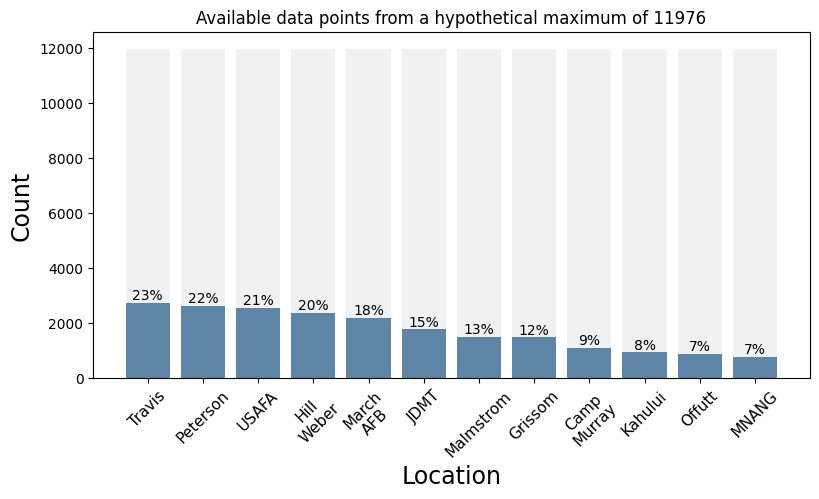

In [4]:
utils.visualise_missing_data(raw)

### Discrepancy between descriptive statistics here and in the paper
Calculating descriptive statistics for the numerical columns, it's noted that the values here differ from those in the paper for some of the features (see `variable units.png`). After investigating, the differences were due to approximately constant scaling factors for each feature, indicating some change of units had taken place. The function `fix_units()` calculates these and transforms the features accordingly. The second set of statistics is then left closely matching those in the paper.

In [5]:
numerical_features = [f for f in raw.columns if f not in ['Datetime', 'Season', 'Latitude', 'Longitude', 'Location']]

raw[numerical_features].describe().round(3).loc[['min', '25%', '50%', 'mean', '75%', 'max']].T

,min,25%,50%,mean,75%,max
Altitude,1.000,2.000,458.000,798.844,1370.000,1947.000
Humidity,0.000,17.529,33.124,37.122,52.594,99.988
AmbientTemp,-19.982,21.915,30.289,29.285,37.475,65.738
Wind.Speed,0.000,6.000,9.000,10.318,14.000,49.000
Visibility,0.000,10.000,10.000,9.700,10.000,10.000
Pressure,781.700,845.500,961.100,925.945,1008.900,1029.500
Cloud.Ceiling,0.000,140.000,722.000,515.967,722.000,722.000
PolyPwr,0.257,6.405,13.799,12.979,18.864,34.285


In [6]:
raw_clean = utils.fix_units(raw)

raw_clean[numerical_features].describe().round(3).loc[['min', '25%', '50%', 'mean', '75%', 'max']].T

,min,25%,50%,mean,75%,max
Altitude,0.303,0.607,138.932,242.325,415.582,590.612
Humidity,0.000,17.529,33.124,37.122,52.594,99.988
AmbientTemp,-19.982,21.915,30.289,29.285,37.475,65.738
Wind.Speed,0.000,9.665,14.497,16.621,22.551,78.929
Visibility,0.000,16.096,16.096,15.614,16.096,16.096
Pressure,781.700,845.500,961.100,925.945,1008.900,1029.500
Cloud.Ceiling,0.000,4.272,22.029,15.743,22.029,22.029
PolyPwr,0.257,6.405,13.799,12.979,18.864,34.285


With that done, we can rename the column headings and include the appropriate units. We also note at this stage that there are large variations in the scales, max and min values of the features and we'll need some scaling prior to modelling to ensure good performance. 

In [7]:
raw_clean.columns = ['Datetime', 'Location', 'Latitude (deg)', 'Longitude (deg)', 'Altitude (m)', 'Season',
       'Humidity (%)', 'AmbientTemp (deg C)', 'WindSpeed (km/h)', 'Visibility (km)', 'Pressure (mbar)',
       'CloudCeiling (km)', 'Power (W)']

numerical_features = [f for f in raw_clean.columns if f not in ['Datetime', 'Season', 'Latitude (deg)', 'Longitude (deg)', 'Altitude (m)', 'Location']]

## Exploration of features

We'll begin with an exploration of the entire dataset since that was the approach taken in the paper. If we decide to try forecasting by location, we'll conduct an extra exploration for the specific locations we're interested in. 

The correlation matrix gives the Pearson's correlation between features assuming Gaussian distributions. We note that temperature is most highly correlated with the target. Wind speed and pressure have small (<0.1%) correlations, though how informative this is will depend on the shapes of the particular distributions. There are no high correlations among the base features. 

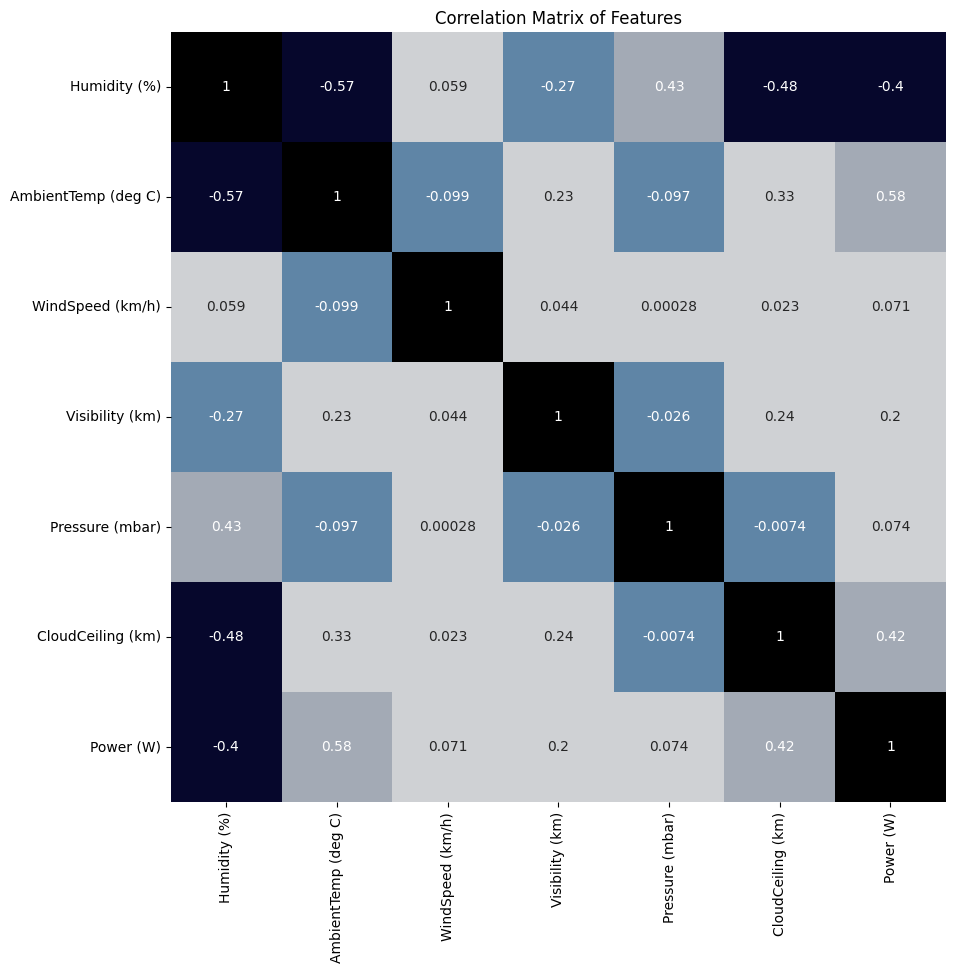

In [8]:
# Correlation
utils.correlation_matrix(raw_clean[numerical_features])

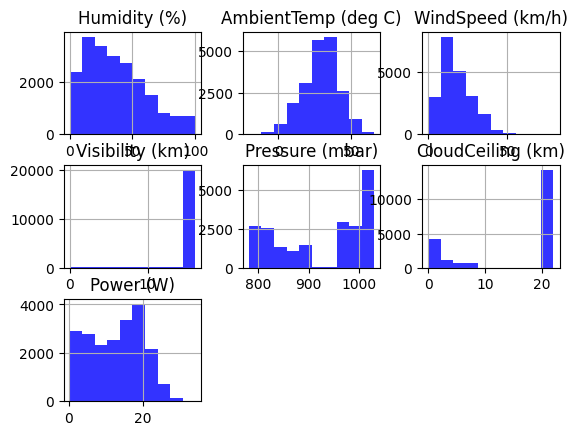

In [9]:
raw_clean[numerical_features].hist(color='blue', alpha=0.8);

Cols: 3


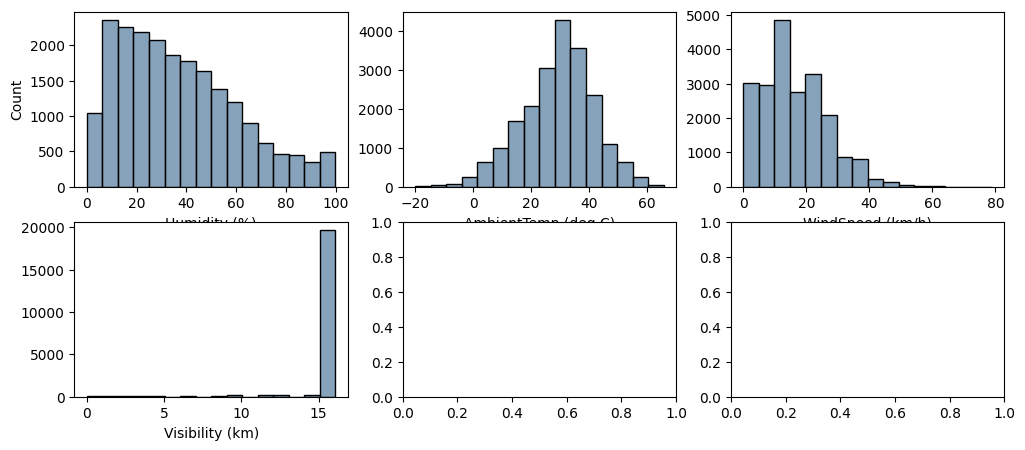

In [51]:
FONT_SIZE_TICKS = None
FONT_SIZE_TITLE = None
FONT_SIZE_AXES = None

colors = {'white': '#fdfdfd',
          'dark blue': '#06072c',
          'chalk blue': '#5f85a6',
          'light gray': '#cfd1d4',
          'blue gray': '#a3aab5',
          'black': '#000000'}

COLORS = [v for v in colors.values()]

sns.set_palette(sns.color_palette(COLORS))

features = numerical_features[:4]
bins = 16

data = raw_clean.copy()

n_plots = len(features)
cols = (n_plots if n_plots < 3 else 3)
print(f"Cols: {cols}")
rows = n_plots // 3 + 1

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 5))

for i, ax_ in enumerate(ax.flatten()):
    if i == n_plots:
        break
    x = data[features[i]].values
    sns.histplot(x, bins=bins, color=COLORS[2], ax=ax_)
    ax_.set_xlabel(f"{features[i]}", fontsize=FONT_SIZE_AXES)
    ylabel = ("Count" if i == 0 else "")
    ax_.set_ylabel(ylabel, fontsize=FONT_SIZE_AXES)
    # plt.title(f"{feature}", fontsize=FONT_SIZE_TITLE)
    ax_.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)
plt.show()


In [37]:
2 // 3

0

In [ ]:
plt.figure(figsize = (18, 4))
plt.subplot(121); plt.imshow(img_ori[:,:,::-1]); plt.title('Original')
plt.subplot(122); plt.imshow(g_seg[:, :, ::-1]); plt.title('Segmented');


In [ ]:
raw_clean[numerical_features].skew().to_frame()

,0
Humidity (%),0.665258
AmbientTemp (deg C),-0.326469
WindSpeed (km/h),0.627086
Visibility (km),-5.144763
Pressure (mbar),-0.358878
CloudCeiling (km),-0.822479
Power (W),-0.035347


In [ ]:
# Skew
raw_clean.groupby('Location')[numerical_features].skew()

,Humidity (%),AmbientTemp (deg C),WindSpeed (km/h),Visibility (km),Pressure (mbar),CloudCeiling (km),Power (W)
Location,,,,,,,
Camp Murray,0.665791,0.116363,0.402247,-3.002569,0.048550,0.125685,0.318747
Grissom,0.314833,-0.478554,0.515192,-4.094821,0.560071,-0.130174,0.658011
Hill Weber,1.392586,-0.047395,0.686735,-6.562912,0.305015,-0.848252,-0.260705
JDMT,0.962768,-0.680905,0.528058,-4.592785,0.186817,-0.088274,-0.393749
Kahului,0.724939,0.011600,-0.560913,-7.334924,-0.582981,-1.763334,-0.258627
MNANG,0.115227,-0.575028,0.459709,-5.157851,0.356892,0.045072,0.331343
Malmstrom,0.745637,-0.235179,0.706713,-3.381766,0.053168,-0.878387,0.465352
March AFB,1.211055,-0.323668,0.359731,-8.780616,0.559082,-2.340362,-0.539295
Offutt,0.376101,-0.660903,0.585551,-5.659998,-0.040502,-0.817642,-0.366661


### By location

The following plots can be used to compare the distributions of various numerical features at each location, individually or side-by-side. We see that the power output, the target variable, often exhibits approximately bimodal distributions with the locations of the central peaks varying from site to site and with peak frequency occurring at high power in some cases (e.g. USAFA) and low power in others (e.g. Malmstrom). It can be seen from the violin/box plots that all features vary substantially with location. 

In [ ]:
utils.compare_box_violins(raw_clean, numerical_features)

interactive(children=(Dropdown(description='Feature', index=6, options=('Humidity (%)', 'AmbientTemp (deg C)',…

In [ ]:
utils.compare_histograms(raw_clean, numerical_features, bins=16)

interactive(children=(Dropdown(description='Location 1', index=10, options=('Camp Murray', 'Grissom', 'Hill We…

Features can 

In [ ]:
utils.scatterplot(raw_clean, numerical_features)

interactive(children=(Dropdown(description='Location', index=11, options=('Camp Murray', 'Grissom', 'Hill Webe…

### Time variation of power by location
The variation of average power with location can be explored using the graphic below. We see that there are a range of differing behaviours depending on the particular site. 

In [ ]:
data = raw_clean.copy()
time_increment = 'month_of_year' # Can also aggregate by 'hour_of_day'
utils.create_map(data, time_increment=time_increment)


/Users/douglaslazenby/Documents/Projects/solar-forecasting/utils.py:173: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped_means[index[0]][index[1]] = row[0]
/Users/douglaslazenby/Documents/Projects/solar-forecasting/utils.py:174: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped_stds[index[0]][index[1]] = row[1]


<Figure size 640x480 with 0 Axes>